# KMC simulation of PLD

In [1]:
#!pip install tensorflow keras

In [2]:
#!pip install tensorflow-gpu

In [3]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time

In [4]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    
    return full_atom_box, -1*rms_val

def run_sim_with_chosen_action(s,state,action):
    #Given simulation model s2, the state (i.e., atom positions)
    #and the action (integer 0-5 inclusive), convert action to new deposition rate, and rerun the simulation
    #with the new parameters
    
    #First write a new parameters file
    dep_rates = [0.10,0.15, 0.20, 0.25, 0.30, 0.35]
    new_dep_rate = dep_rates[action]
    new_diff_rate = 0.1

    new_params = collections.OrderedDict()
    new_params ['deposition']= new_dep_rate
    new_params['diffusion']= new_diff_rate
    new_parms_file_name = 'new_params'
    new_input_configuration_file = 'kmc_new.input'
    new_output_config_file = 'new_output.xyz'
    new_traj_file = 'new_kmc.trj'
    new_stats_file = 'new_statistics.dat'
    new_latt_file = 'ni_new.xyz'
    
    input_settings = collections.OrderedDict()
    input_settings['time'] = 1.0
    input_settings['print_period'] = 10.0 
    input_settings[ 'save_traj_period'] = 10.0
    input_settings['param_file'] =  new_parms_file_name
    input_settings['incfg_file']= new_latt_file
    input_settings['outcfg_file']= new_output_config_file
    input_settings['trj_file']=new_traj_file
    input_settings['stats_file']= new_stats_file

    write_params_file(input_settings, new_params)
    arr = s.kmc.get_conf()
    arr_1 = np.array(arr[0])
    
    #Now we need to write the lattice to the file
    write_new_input_file(input_settings, new_input_configuration_file)
    write_params_file(input_settings, new_params)
    write_lattice_to_file(input_settings,arr_1, latt)

    s2=RunSim()
    s2.read(new_input_configuration_file)
    s2.init_sim()
    s2.run(verbose=False)
    
    #Now get the state and reward
    state, reward = get_state_reward(s2)
            
    return state, reward, s2

In [5]:
#Need to hold the state in memory and hten 

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [8]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [9]:
wdir = '../data/working'

In [10]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [11]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [12]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [13]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [14]:
sim = RunSim()

In [15]:
sim.read(os.path.join(wdir,'kmc.input'))

In [16]:
sim.init_sim()

Number of events: [512   0   0]
tree level 0 (4,)
tree level 1 (2,)
tree level 2 (1,)


In [17]:
sim.run()

Event type: 0, N_Events: [512   0   0]
# event: (0, 26, 12, 4, 26, 12, 4) ev# [512, 0, 0]at# 2048 gr# 1 lxyz [30 31  3]
Event type: 0, N_Events: [511   0   0]
# event: (0, 25, 13, 4, 25, 13, 4) ev# [511, 0, 0]at# 2049 gr# 2 lxyz [26 12  4]
Event type: 0, N_Events: [510   0   0]
# event: (0, 22, 6, 4, 22, 6, 4) ev# [510, 0, 0]at# 2050 gr# 2 lxyz [25 13  4]
Event type: 0, N_Events: [509   0   0]
# event: (0, 10, 24, 4, 10, 24, 4) ev# [509, 0, 0]at# 2051 gr# 3 lxyz [22  6  4]
Event type: 0, N_Events: [508   0   0]
# event: (0, 4, 20, 4, 4, 20, 4) ev# [508, 0, 0]at# 2052 gr# 4 lxyz [10 24  4]
Event type: 0, N_Events: [507   0   0]
# event: (0, 31, 5, 4, 31, 5, 4) ev# [507, 0, 0]at# 2053 gr# 5 lxyz [ 4 20  4]
Event type: 0, N_Events: [506   0   0]
# event: (0, 11, 5, 4, 11, 5, 4) ev# [506, 0, 0]at# 2054 gr# 6 lxyz [31  5  4]
Event type: 0, N_Events: [505   0   0]
# event: (0, 16, 30, 4, 16, 30, 4) ev# [505, 0, 0]at# 2055 gr# 7 lxyz [11  5  4]
Event type: 0, N_Events: [504   0   0]
# event: 

Event type: 0, N_Events: [441   0   0]
# event: (0, 3, 19, 4, 3, 19, 4) ev# [441, 0, 0]at# 2124 gr# 56 lxyz [26 20  4]
Event type: 0, N_Events: [441   0   0]
# event: (0, 13, 1, 4, 13, 1, 4) ev# [441, 0, 0]at# 2125 gr# 56 lxyz [ 3 19  4]
Event type: 0, N_Events: [440   0   0]
# event: (0, 3, 29, 4, 3, 29, 4) ev# [440, 0, 0]at# 2126 gr# 57 lxyz [13  1  4]
Event type: 0, N_Events: [440   0   0]
# event: (0, 12, 0, 4, 12, 0, 4) ev# [440, 0, 0]at# 2127 gr# 57 lxyz [ 3 29  4]
Event type: 0, N_Events: [439   0   0]
# event: (0, 29, 27, 4, 29, 27, 4) ev# [439, 0, 0]at# 2128 gr# 57 lxyz [12  0  4]
Event type: 0, N_Events: [438   0   0]
# event: (0, 17, 17, 4, 17, 17, 4) ev# [438, 0, 0]at# 2129 gr# 57 lxyz [29 27  4]
Event type: 0, N_Events: [437   0   0]
# event: (0, 21, 29, 4, 21, 29, 4) ev# [437, 0, 0]at# 2130 gr# 58 lxyz [17 17  4]
Event type: 0, N_Events: [436   0   0]
# event: (0, 18, 2, 4, 18, 2, 4) ev# [436, 0, 0]at# 2131 gr# 58 lxyz [21 29  4]
Event type: 0, N_Events: [435   0   0]
# e

Event type: 0, N_Events: [407   8   0]
# event: (0, 14, 11, 5, 14, 11, 5) ev# [407, 8, 0]at# 2210 gr# 80 lxyz [ 3 25  4]
Event type: 0, N_Events: [409  11   0]
# event: (0, 24, 8, 4, 24, 8, 4) ev# [409, 11, 0]at# 2211 gr# 80 lxyz [14 11  5]
Event type: 0, N_Events: [409  11   0]
# event: (0, 30, 24, 4, 30, 24, 4) ev# [409, 11, 0]at# 2212 gr# 80 lxyz [24  8  4]
Event type: 0, N_Events: [408  11   0]
# event: (0, 24, 13, 5, 24, 13, 5) ev# [408, 11, 0]at# 2213 gr# 81 lxyz [30 24  4]
Event type: 0, N_Events: [410  14   0]
# event: (0, 20, 7, 5, 20, 7, 5) ev# [410, 14, 0]at# 2214 gr# 81 lxyz [24 13  5]
Event type: 0, N_Events: [411  16   0]
# event: (0, 16, 4, 4, 16, 4, 4) ev# [411, 16, 0]at# 2215 gr# 81 lxyz [20  7  5]
Event type: 0, N_Events: [412  16   0]
# event: (0, 9, 31, 4, 9, 31, 4) ev# [412, 16, 0]at# 2216 gr# 81 lxyz [16  4  4]
Event type: 0, N_Events: [411  16   0]
# event: (0, 11, 3, 4, 11, 3, 4) ev# [411, 16, 0]at# 2217 gr# 81 lxyz [ 9 31  4]
Event type: 0, N_Events: [410  16  

# event: (0, 14, 14, 4, 14, 14, 4) ev# [409, 21, 0]at# 2277 gr# 86 lxyz [8 0 4]
Event type: 0, N_Events: [409  21   0]
# event: (0, 0, 22, 4, 0, 22, 4) ev# [409, 21, 0]at# 2278 gr# 86 lxyz [14 14  4]
Event type: 0, N_Events: [408  21   0]
# event: (0, 6, 23, 5, 6, 23, 5) ev# [408, 21, 0]at# 2279 gr# 86 lxyz [ 0 22  4]
Event type: 0, N_Events: [409  22   0]
# event: (0, 11, 17, 4, 11, 17, 4) ev# [409, 22, 0]at# 2280 gr# 86 lxyz [ 6 23  5]
Event type: 1, N_Events: [410  22   0]
# event: (1, 30, 5, 5, 29, 4, 5) ev# [410, 22, 0]at# 2281 gr# 86 lxyz [11 17  4]
Event type: 0, N_Events: [410  22   0]
# event: (0, 7, 5, 4, 7, 5, 4) ev# [410, 22, 0]at# 2281 gr# 86 lxyz [11 17  4]
Event type: 0, N_Events: [411  22   0]
# event: (0, 13, 29, 4, 13, 29, 4) ev# [411, 22, 0]at# 2282 gr# 86 lxyz [7 5 4]
Event type: 0, N_Events: [411  22   0]
# event: (0, 20, 10, 4, 20, 10, 4) ev# [411, 22, 0]at# 2283 gr# 86 lxyz [13 29  4]
Event type: 0, N_Events: [411  22   0]
# event: (0, 23, 10, 5, 23, 10, 5) ev# [

# event: (1, 7, 14, 5, 8, 15, 5) ev# [432, 48, 0]at# 2341 gr# 90 lxyz [7 9 4]
Event type: 0, N_Events: [434  50   0]
# event: (0, 25, 5, 4, 25, 5, 4) ev# [434, 50, 0]at# 2341 gr# 90 lxyz [7 9 4]
Event type: 0, N_Events: [434  50   0]
# event: (0, 12, 31, 5, 12, 31, 5) ev# [434, 50, 0]at# 2342 gr# 90 lxyz [25  5  4]
Event type: 1, N_Events: [435  51   0]
# event: (1, 3, 30, 5, 2, 29, 5) ev# [435, 51, 0]at# 2343 gr# 90 lxyz [12 31  5]
Event type: 0, N_Events: [434  50   0]
# event: (0, 9, 9, 4, 9, 9, 4) ev# [434, 50, 0]at# 2343 gr# 90 lxyz [12 31  5]
Event type: 0, N_Events: [436  50   0]
# event: (0, 15, 15, 4, 15, 15, 4) ev# [436, 50, 0]at# 2344 gr# 90 lxyz [9 9 4]
Event type: 0, N_Events: [436  50   0]
# event: (0, 14, 30, 4, 14, 30, 4) ev# [436, 50, 0]at# 2345 gr# 90 lxyz [15 15  4]
Event type: 0, N_Events: [435  50   0]
# event: (0, 19, 18, 5, 19, 18, 5) ev# [435, 50, 0]at# 2346 gr# 90 lxyz [14 30  4]
Event type: 0, N_Events: [436  52   0]
# event: (0, 3, 15, 4, 3, 15, 4) ev# [436, 

# event: (1, 25, 12, 5, 26, 13, 5) ev# [460, 71, 0]at# 2412 gr# 94 lxyz [31  7  4]
Event type: 1, N_Events: [460  70   0]
# event: (1, 12, 31, 5, 11, 30, 5) ev# [460, 70, 0]at# 2412 gr# 94 lxyz [31  7  4]
Event type: 0, N_Events: [460  70   0]
# event: (0, 26, 0, 4, 26, 0, 4) ev# [460, 70, 0]at# 2412 gr# 94 lxyz [31  7  4]
Event type: 1, N_Events: [460  70   0]
# event: (1, 7, 22, 5, 8, 23, 5) ev# [460, 70, 0]at# 2413 gr# 94 lxyz [26  0  4]
Event type: 0, N_Events: [461  70   0]
# event: (0, 16, 11, 5, 16, 11, 5) ev# [461, 70, 0]at# 2413 gr# 94 lxyz [26  0  4]
Event type: 1, N_Events: [461  69   0]
# event: (1, 28, 1, 5, 27, 0, 5) ev# [461, 69, 0]at# 2414 gr# 94 lxyz [16 11  5]
Event type: 0, N_Events: [462  70   0]
# event: (0, 17, 25, 4, 17, 25, 4) ev# [462, 70, 0]at# 2414 gr# 94 lxyz [16 11  5]
Event type: 0, N_Events: [462  70   0]
# event: (0, 26, 9, 5, 26, 9, 5) ev# [462, 70, 0]at# 2415 gr# 94 lxyz [17 25  4]
Event type: 0, N_Events: [461  70   0]
# event: (0, 1, 30, 5, 1, 30, 5)

# event: (0, 10, 26, 4, 10, 26, 4) ev# [471, 70, 0]at# 2511 gr# 94 lxyz [30 30  6]
Event type: 1, N_Events: [471  68   0]
# event: (1, 16, 10, 6, 15, 9, 6) ev# [471, 68, 0]at# 2512 gr# 94 lxyz [10 26  4]
Event type: 0, N_Events: [471  67   0]
# event: (0, 20, 26, 4, 20, 26, 4) ev# [471, 67, 0]at# 2512 gr# 94 lxyz [10 26  4]
Event type: 0, N_Events: [471  67   0]
# event: (0, 8, 20, 4, 8, 20, 4) ev# [471, 67, 0]at# 2513 gr# 94 lxyz [20 26  4]
Event type: 0, N_Events: [470  66   0]
# event: (0, 25, 4, 5, 25, 4, 5) ev# [470, 66, 0]at# 2514 gr# 94 lxyz [ 8 20  4]
Event type: 0, N_Events: [469  65   0]
# event: (0, 3, 7, 4, 3, 7, 4) ev# [469, 65, 0]at# 2515 gr# 94 lxyz [25  4  5]
Event type: 0, N_Events: [469  63   0]
# event: (0, 1, 24, 5, 1, 24, 5) ev# [469, 63, 0]at# 2516 gr# 94 lxyz [3 7 4]
Event type: 0, N_Events: [469  63   0]
# event: (0, 15, 10, 5, 15, 10, 5) ev# [469, 63, 0]at# 2517 gr# 94 lxyz [ 1 24  5]
Event type: 0, N_Events: [470  64   0]
# event: (0, 18, 21, 5, 18, 21, 5) ev#

# event: (0, 25, 29, 4, 25, 29, 4) ev# [480, 65, 0]at# 2576 gr# 94 lxyz [ 3 15  6]
Event type: 0, N_Events: [480  65   0]
# event: (0, 12, 3, 5, 12, 3, 5) ev# [480, 65, 0]at# 2577 gr# 94 lxyz [25 29  4]
Event type: 0, N_Events: [479  65   0]
# event: (0, 4, 16, 6, 4, 16, 6) ev# [479, 65, 0]at# 2578 gr# 94 lxyz [12  3  5]
Event type: 0, N_Events: [479  65   0]
# event: (0, 23, 31, 4, 23, 31, 4) ev# [479, 65, 0]at# 2579 gr# 94 lxyz [ 4 16  6]
Event type: 0, N_Events: [478  64   0]
# event: (0, 25, 9, 6, 25, 9, 6) ev# [478, 64, 0]at# 2580 gr# 94 lxyz [23 31  4]
Event type: 0, N_Events: [479  66   0]
# event: (0, 25, 1, 4, 25, 1, 4) ev# [479, 66, 0]at# 2581 gr# 94 lxyz [25  9  6]
Event type: 0, N_Events: [479  66   0]
# event: (0, 19, 12, 5, 19, 12, 5) ev# [479, 66, 0]at# 2582 gr# 94 lxyz [25  1  4]
Event type: 0, N_Events: [478  65   0]
# event: (0, 11, 25, 4, 11, 25, 4) ev# [478, 65, 0]at# 2583 gr# 94 lxyz [19 12  5]
Event type: 0, N_Events: [477  65   0]
# event: (0, 24, 29, 5, 24, 29, 

Event type: 0, N_Events: [488  69   0]
# event: (0, 29, 14, 5, 29, 14, 5) ev# [488, 69, 0]at# 2642 gr# 94 lxyz [24 10  6]
Event type: 0, N_Events: [489  70   0]
# event: (0, 9, 24, 5, 9, 24, 5) ev# [489, 70, 0]at# 2643 gr# 94 lxyz [29 14  5]
Event type: 0, N_Events: [488  70   0]
# event: (0, 31, 25, 4, 31, 25, 4) ev# [488, 70, 0]at# 2644 gr# 94 lxyz [ 9 24  5]
Event type: 0, N_Events: [488  70   0]
# event: (0, 25, 25, 4, 25, 25, 4) ev# [488, 70, 0]at# 2645 gr# 94 lxyz [31 25  4]
Event type: 1, N_Events: [487  70   0]
# event: (1, 29, 8, 5, 28, 7, 5) ev# [487, 70, 0]at# 2646 gr# 94 lxyz [25 25  4]
Event type: 1, N_Events: [488  70   0]
# event: (1, 28, 7, 5, 27, 8, 5) ev# [488, 70, 0]at# 2646 gr# 94 lxyz [25 25  4]
Event type: 0, N_Events: [488  69   0]
# event: (0, 14, 20, 4, 14, 20, 4) ev# [488, 69, 0]at# 2646 gr# 94 lxyz [25 25  4]
Event type: 0, N_Events: [489  69   0]
# event: (0, 28, 27, 5, 28, 27, 5) ev# [489, 69, 0]at# 2647 gr# 94 lxyz [14 20  4]
Event type: 0, N_Events: [488 

# event: (0, 19, 28, 5, 19, 28, 5) ev# [493, 66, 0]at# 2731 gr# 95 lxyz [22 21  5]
Event type: 0, N_Events: [493  66   0]
# event: (0, 25, 14, 5, 25, 14, 5) ev# [493, 66, 0]at# 2732 gr# 95 lxyz [19 28  5]
Event type: 0, N_Events: [495  66   0]
# event: (0, 1, 16, 5, 1, 16, 5) ev# [495, 66, 0]at# 2733 gr# 95 lxyz [25 14  5]
Event type: 0, N_Events: [495  66   0]
# event: (0, 27, 7, 4, 27, 7, 4) ev# [495, 66, 0]at# 2734 gr# 95 lxyz [ 1 16  5]
Event type: 0, N_Events: [495  66   0]
# event: (0, 10, 23, 5, 10, 23, 5) ev# [495, 66, 0]at# 2735 gr# 95 lxyz [27  7  4]
Event type: 0, N_Events: [497  66   0]
# event: (0, 12, 7, 5, 12, 7, 5) ev# [497, 66, 0]at# 2736 gr# 95 lxyz [10 23  5]
Event type: 0, N_Events: [498  66   0]
# event: (0, 18, 17, 5, 18, 17, 5) ev# [498, 66, 0]at# 2737 gr# 95 lxyz [12  7  5]
Event type: 0, N_Events: [498  66   0]
# event: (0, 9, 22, 5, 9, 22, 5) ev# [498, 66, 0]at# 2738 gr# 95 lxyz [18 17  5]
Event type: 0, N_Events: [498  67   0]
# event: (0, 22, 3, 5, 22, 3, 5)

# event: (0, 30, 5, 5, 30, 5, 5) ev# [508, 60, 0]at# 2814 gr# 95 lxyz [12 28  4]
Event type: 0, N_Events: [508  60   0]
# event: (0, 27, 9, 4, 27, 9, 4) ev# [508, 60, 0]at# 2815 gr# 95 lxyz [30  5  5]
Event type: 0, N_Events: [507  60   0]
# event: (0, 14, 23, 5, 14, 23, 5) ev# [507, 60, 0]at# 2816 gr# 95 lxyz [27  9  4]
Event type: 0, N_Events: [508  60   0]
# event: (0, 2, 20, 4, 2, 20, 4) ev# [508, 60, 0]at# 2817 gr# 95 lxyz [14 23  5]
Event type: 0, N_Events: [507  60   0]
# event: (0, 5, 11, 6, 5, 11, 6) ev# [507, 60, 0]at# 2818 gr# 95 lxyz [ 2 20  4]
Event type: 0, N_Events: [508  61   0]
# event: (0, 11, 2, 5, 11, 2, 5) ev# [508, 61, 0]at# 2819 gr# 95 lxyz [ 5 11  6]
Event type: 0, N_Events: [508  61   0]
# event: (0, 19, 23, 6, 19, 23, 6) ev# [508, 61, 0]at# 2820 gr# 95 lxyz [11  2  5]
Event type: 1, N_Events: [508  61   0]
# event: (1, 2, 1, 5, 3, 2, 5) ev# [508, 61, 0]at# 2821 gr# 95 lxyz [19 23  6]
Event type: 0, N_Events: [508  61   0]
# event: (0, 29, 12, 5, 29, 12, 5) ev#

# event: (0, 23, 20, 5, 23, 20, 5) ev# [520, 72, 0]at# 2892 gr# 95 lxyz [21 20  5]
Event type: 0, N_Events: [520  72   0]
# event: (0, 23, 28, 5, 23, 28, 5) ev# [520, 72, 0]at# 2893 gr# 95 lxyz [23 20  5]
Event type: 0, N_Events: [520  72   0]
# event: (0, 12, 17, 5, 12, 17, 5) ev# [520, 72, 0]at# 2894 gr# 95 lxyz [23 28  5]
Event type: 0, N_Events: [520  72   0]
# event: (0, 6, 31, 5, 6, 31, 5) ev# [520, 72, 0]at# 2895 gr# 95 lxyz [12 17  5]
Event type: 1, N_Events: [519  72   0]
# event: (1, 1, 23, 6, 2, 24, 6) ev# [519, 72, 0]at# 2896 gr# 95 lxyz [ 6 31  5]
Event type: 0, N_Events: [520  70   0]
# event: (0, 10, 21, 5, 10, 21, 5) ev# [520, 70, 0]at# 2896 gr# 95 lxyz [ 6 31  5]
Event type: 0, N_Events: [520  69   0]
# event: (0, 31, 10, 5, 31, 10, 5) ev# [520, 69, 0]at# 2897 gr# 95 lxyz [10 21  5]
Event type: 0, N_Events: [521  69   0]
# event: (0, 29, 3, 6, 29, 3, 6) ev# [521, 69, 0]at# 2898 gr# 95 lxyz [31 10  5]
Event type: 0, N_Events: [521  70   0]
# event: (0, 31, 23, 6, 31, 23

Event type: 0, N_Events: [536  64   0]
# event: (0, 23, 6, 5, 23, 6, 5) ev# [536, 64, 0]at# 2966 gr# 95 lxyz [ 4 27  7]
Event type: 0, N_Events: [535  64   0]
# event: (0, 15, 7, 4, 15, 7, 4) ev# [535, 64, 0]at# 2967 gr# 95 lxyz [23  6  5]
Event type: 0, N_Events: [534  64   0]
# event: (0, 17, 21, 6, 17, 21, 6) ev# [534, 64, 0]at# 2968 gr# 95 lxyz [15  7  4]
Event type: 0, N_Events: [533  64   0]
# event: (0, 21, 2, 5, 21, 2, 5) ev# [533, 64, 0]at# 2969 gr# 95 lxyz [17 21  6]
Event type: 0, N_Events: [533  64   0]
# event: (0, 11, 7, 6, 11, 7, 6) ev# [533, 64, 0]at# 2970 gr# 95 lxyz [21  2  5]
Event type: 1, N_Events: [532  64   0]
# event: (1, 13, 15, 6, 12, 16, 6) ev# [532, 64, 0]at# 2971 gr# 95 lxyz [11  7  6]
Event type: 0, N_Events: [531  65   0]
# event: (0, 26, 7, 5, 26, 7, 5) ev# [531, 65, 0]at# 2971 gr# 95 lxyz [11  7  6]
Event type: 0, N_Events: [531  66   0]
# event: (0, 8, 12, 6, 8, 12, 6) ev# [531, 66, 0]at# 2972 gr# 95 lxyz [26  7  5]
Event type: 0, N_Events: [533  67   

Event type: 0, N_Events: [541  71   0]
# event: (0, 29, 9, 6, 29, 9, 6) ev# [541, 71, 0]at# 3038 gr# 95 lxyz [16 17  5]
Event type: 0, N_Events: [540  71   0]
# event: (0, 12, 20, 6, 12, 20, 6) ev# [540, 71, 0]at# 3039 gr# 95 lxyz [29  9  6]
Event type: 0, N_Events: [540  71   0]
# event: (0, 3, 7, 6, 3, 7, 6) ev# [540, 71, 0]at# 3040 gr# 95 lxyz [12 20  6]
Event type: 0, N_Events: [541  72   0]
# event: (0, 12, 13, 5, 12, 13, 5) ev# [541, 72, 0]at# 3041 gr# 95 lxyz [3 7 6]
Event type: 0, N_Events: [541  72   0]
# event: (0, 12, 8, 6, 12, 8, 6) ev# [541, 72, 0]at# 3042 gr# 95 lxyz [12 13  5]
Event type: 0, N_Events: [543  72   0]
# event: (0, 11, 31, 6, 11, 31, 6) ev# [543, 72, 0]at# 3043 gr# 95 lxyz [12  8  6]
Event type: 0, N_Events: [545  72   0]
# event: (0, 10, 30, 4, 10, 30, 4) ev# [545, 72, 0]at# 3044 gr# 95 lxyz [11 31  6]
Event type: 0, N_Events: [544  72   0]
# event: (0, 30, 7, 5, 30, 7, 5) ev# [544, 72, 0]at# 3045 gr# 95 lxyz [10 30  4]
Event type: 0, N_Events: [545  72   0

# event: (0, 20, 2, 6, 20, 2, 6) ev# [548, 71, 0]at# 3174 gr# 95 lxyz [28 15  7]
Event type: 0, N_Events: [548  71   0]
# event: (0, 25, 26, 5, 25, 26, 5) ev# [548, 71, 0]at# 3175 gr# 95 lxyz [20  2  6]
Event type: 0, N_Events: [548  69   0]
# event: (0, 22, 0, 4, 22, 0, 4) ev# [548, 69, 0]at# 3176 gr# 95 lxyz [25 26  5]
Event type: 0, N_Events: [547  69   0]
# event: (0, 8, 20, 6, 8, 20, 6) ev# [547, 69, 0]at# 3177 gr# 95 lxyz [22  0  4]
Event type: 0, N_Events: [546  69   0]
# event: (0, 20, 5, 5, 20, 5, 5) ev# [546, 69, 0]at# 3178 gr# 95 lxyz [ 8 20  6]
Event type: 0, N_Events: [545  69   0]
# event: (0, 3, 30, 7, 3, 30, 7) ev# [545, 69, 0]at# 3179 gr# 95 lxyz [20  5  5]
Event type: 0, N_Events: [546  70   0]
# event: (0, 3, 24, 7, 3, 24, 7) ev# [546, 70, 0]at# 3180 gr# 95 lxyz [ 3 30  7]
Event type: 0, N_Events: [545  70   0]
# event: (0, 31, 17, 4, 31, 17, 4) ev# [545, 70, 0]at# 3181 gr# 95 lxyz [ 3 24  7]
Event type: 0, N_Events: [544  70   0]
# event: (0, 31, 9, 6, 31, 9, 6) ev#

Event type: 1, N_Events: [555  68   0]
# event: (1, 22, 11, 7, 23, 12, 7) ev# [555, 68, 0]at# 3236 gr# 95 lxyz [23  1  4]
Event type: 0, N_Events: [556  70   0]
# event: (0, 12, 18, 6, 12, 18, 6) ev# [556, 70, 0]at# 3236 gr# 95 lxyz [23  1  4]
Event type: 0, N_Events: [558  70   0]
# event: (0, 18, 30, 6, 18, 30, 6) ev# [558, 70, 0]at# 3237 gr# 95 lxyz [12 18  6]
Event type: 0, N_Events: [558  70   0]
# event: (0, 28, 19, 5, 28, 19, 5) ev# [558, 70, 0]at# 3238 gr# 95 lxyz [18 30  6]
Event type: 0, N_Events: [557  70   0]
# event: (0, 26, 18, 6, 26, 18, 6) ev# [557, 70, 0]at# 3239 gr# 95 lxyz [28 19  5]
Event type: 1, N_Events: [557  69   0]
# event: (1, 23, 1, 6, 24, 0, 6) ev# [557, 69, 0]at# 3240 gr# 95 lxyz [26 18  6]
Event type: 0, N_Events: [555  67   0]
# event: (0, 14, 17, 7, 14, 17, 7) ev# [555, 67, 0]at# 3240 gr# 95 lxyz [26 18  6]
Event type: 0, N_Events: [554  67   0]
# event: (0, 11, 12, 7, 11, 12, 7) ev# [554, 67, 0]at# 3241 gr# 95 lxyz [14 17  7]
Event type: 0, N_Events: [

# event: (0, 17, 31, 6, 17, 31, 6) ev# [547, 62, 0]at# 3292 gr# 95 lxyz [28  4  6]
Event type: 0, N_Events: [549  62   0]
# event: (0, 22, 22, 6, 22, 22, 6) ev# [549, 62, 0]at# 3293 gr# 95 lxyz [17 31  6]
Event type: 0, N_Events: [550  62   0]
# event: (0, 16, 11, 7, 16, 11, 7) ev# [550, 62, 0]at# 3294 gr# 95 lxyz [22 22  6]
Event type: 0, N_Events: [550  62   0]
# event: (0, 27, 14, 7, 27, 14, 7) ev# [550, 62, 0]at# 3295 gr# 95 lxyz [16 11  7]
Event type: 0, N_Events: [550  62   0]
# event: (0, 11, 14, 7, 11, 14, 7) ev# [550, 62, 0]at# 3296 gr# 95 lxyz [27 14  7]
Event type: 0, N_Events: [550  63   0]
# event: (0, 5, 7, 6, 5, 7, 6) ev# [550, 63, 0]at# 3297 gr# 95 lxyz [11 14  7]
Event type: 1, N_Events: [551  63   0]
# event: (1, 23, 20, 7, 24, 19, 7) ev# [551, 63, 0]at# 3298 gr# 95 lxyz [5 7 6]
Event type: 0, N_Events: [551  64   0]
# event: (0, 3, 7, 6, 3, 7, 6) ev# [551, 64, 0]at# 3298 gr# 95 lxyz [5 7 6]
Event type: 1, N_Events: [550  64   0]
# event: (1, 30, 3, 7, 29, 2, 7) ev# [

# event: (0, 30, 6, 6, 30, 6, 6) ev# [562, 73, 0]at# 3358 gr# 95 lxyz [1 7 6]
Event type: 0, N_Events: [564  73   0]
# event: (0, 18, 4, 6, 18, 4, 6) ev# [564, 73, 0]at# 3359 gr# 95 lxyz [30  6  6]
Event type: 0, N_Events: [564  73   0]
# event: (0, 5, 17, 4, 5, 17, 4) ev# [564, 73, 0]at# 3360 gr# 95 lxyz [18  4  6]
Event type: 0, N_Events: [563  73   0]
# event: (0, 5, 10, 5, 5, 10, 5) ev# [563, 73, 0]at# 3361 gr# 95 lxyz [ 5 17  4]
Event type: 0, N_Events: [562  73   0]
# event: (0, 14, 12, 6, 14, 12, 6) ev# [562, 73, 0]at# 3362 gr# 95 lxyz [ 5 10  5]
Event type: 1, N_Events: [562  73   0]
# event: (1, 5, 12, 7, 6, 11, 7) ev# [562, 73, 0]at# 3363 gr# 95 lxyz [14 12  6]
Event type: 0, N_Events: [559  71   0]
# event: (0, 16, 12, 6, 16, 12, 6) ev# [559, 71, 0]at# 3363 gr# 95 lxyz [14 12  6]
Event type: 0, N_Events: [559  71   0]
# event: (0, 4, 22, 6, 4, 22, 6) ev# [559, 71, 0]at# 3364 gr# 95 lxyz [16 12  6]
Event type: 0, N_Events: [560  71   0]
# event: (0, 30, 29, 7, 30, 29, 7) ev# 

# event: (0, 8, 0, 6, 8, 0, 6) ev# [585, 84, 0]at# 3472 gr# 95 lxyz [28  9  7]
Event type: 0, N_Events: [586  83   0]
# event: (0, 15, 8, 7, 15, 8, 7) ev# [586, 83, 0]at# 3473 gr# 95 lxyz [8 0 6]
Event type: 0, N_Events: [586  83   0]
# event: (0, 14, 21, 5, 14, 21, 5) ev# [586, 83, 0]at# 3474 gr# 95 lxyz [15  8  7]
Event type: 0, N_Events: [585  83   0]
# event: (0, 29, 1, 6, 29, 1, 6) ev# [585, 83, 0]at# 3475 gr# 95 lxyz [14 21  5]
Event type: 0, N_Events: [587  85   0]
# event: (0, 27, 31, 6, 27, 31, 6) ev# [587, 85, 0]at# 3476 gr# 95 lxyz [29  1  6]
Event type: 1, N_Events: [586  83   0]
# event: (1, 4, 31, 7, 3, 0, 7) ev# [586, 83, 0]at# 3477 gr# 95 lxyz [27 31  6]
Event type: 0, N_Events: [586  83   0]
# event: (0, 15, 0, 7, 15, 0, 7) ev# [586, 83, 0]at# 3477 gr# 95 lxyz [27 31  6]
Event type: 0, N_Events: [588  83   0]
# event: (0, 30, 28, 8, 30, 28, 8) ev# [588, 83, 0]at# 3478 gr# 95 lxyz [15  0  7]
Event type: 0, N_Events: [588  83   0]
# event: (0, 27, 12, 7, 27, 12, 7) ev# [

In [18]:
grain_numbers = [1,2,4]

In [19]:
if len(grain_numbers)>2 and len(grain_numbers)<4: 
    print('pass')

pass


In [20]:
sim.kmc.etree.find_event()

Event type: 0, N_Events: [580  82   0]


(0, 151)

In [21]:
event_type, event_number = sim.kmc.etree.find_event()

Event type: 0, N_Events: [580  82   0]


In [22]:
sim.kmc.etree.rates

array([0.1, 0.1, 0.1])

In [23]:
tree = sim.kmc.etree.event_tree

In [24]:
tree

[array([58. ,  8.2,  0. ,  0. ]), array([66.2,  0. ]), array([66.2])]

In [25]:
np.random.randint(low=0,high=3)

2

In [26]:
event_number

276

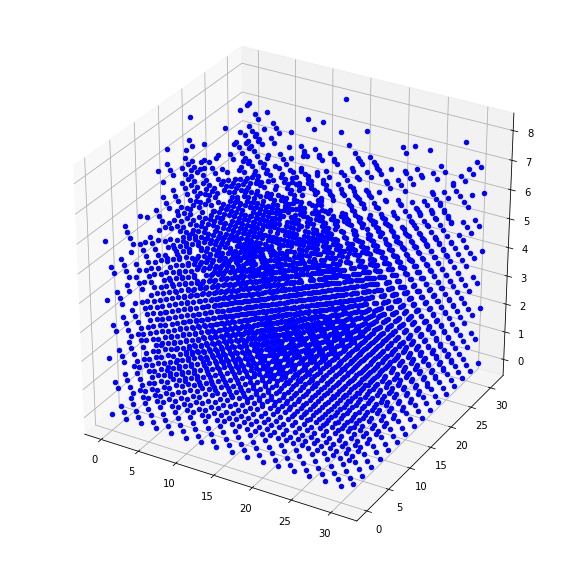

In [27]:
#Get and plot configuration
arr = sim.kmc.get_conf()
arr_1 = np.array(arr[0])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

for x,y,z in arr_1:
    ax.scatter(x,y,z, c = 'b')

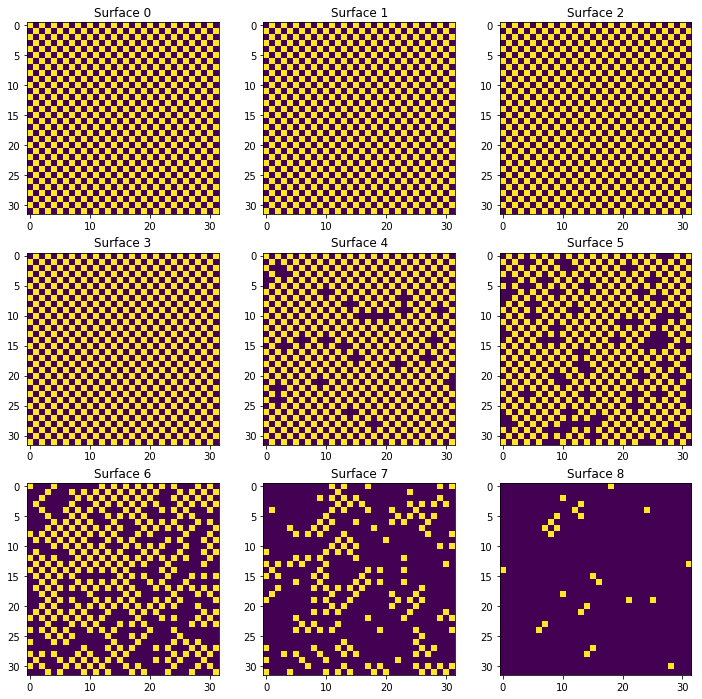

In [28]:
#Convert the x,y,z coordinates into a box
#Because this is an fcc lattice the box should have zeros where no atom will be positioned. 
#The size of the box is just given by nx*ny*nz.

full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
for i,j,k in arr_1:
    full_atom_box[i,j,k]=1

#Plot slices
fig, axes = plt.subplots(nrows=3,ncols=3, figsize = (12,12))
for ind,  ax in enumerate(axes.flat):
    try:
        ax.imshow(full_atom_box[:,:,ind])
        ax.set_title('Surface {}'.format(ind))
    except IndexError:
        pass


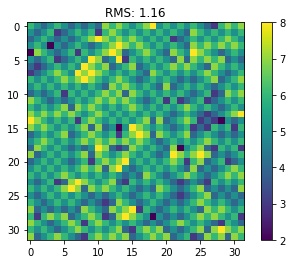

In [29]:
surface_proj = make_surface_proj(full_atom_box)
rms_val = calc_roughness(surface_proj)

plt.figure()
plt.imshow(surface_proj)
plt.colorbar()
plt.title('RMS: ' + str(np.round(rms_val,2)));

In [30]:
new_parms_file_name = 'new_params'
new_input_configuration_file = 'kmc_new.input'
new_output_config_file = 'new_output.xyz'
new_traj_file = 'new_kmc.trj'
new_stats_file = 'new_statistics.dat'
new_latt_file = 'ni_new.xyz'

input_settings = collections.OrderedDict()
input_settings['time'] = 1.0
input_settings['print_period'] = 10.0 
input_settings[ 'save_traj_period'] = 10.0
input_settings['param_file'] =  new_parms_file_name
input_settings['incfg_file']= new_latt_file
input_settings['outcfg_file']= new_output_config_file
input_settings['trj_file']=new_traj_file
input_settings['stats_file']= new_stats_file

new_dep_rate = 0.1
new_diff_rate = 0.1

new_params = collections.OrderedDict()
new_params ['deposition']= new_dep_rate
new_params['diffusion']= new_diff_rate

write_new_input_file(input_settings, new_input_configuration_file)
write_params_file(input_settings, new_params)
write_lattice_to_file(input_settings,arr_1, latt)


In [31]:
sim2 = RunSim()

In [32]:
sim2.read(new_input_configuration_file)

ValueError: could not convert string to float: 'new_params'

In [ ]:
sim2.init_sim()

In [ ]:
sim2.run(verbose=False)

In [ ]:
full_atom_box.shape

# Reinforcement Learning Trial

In [33]:
#Set up the neural network model. Input: atom position box. Output: Choose out of 5 deposition rates ([0.05, 0.1, 0.15, 0.20, 0.25])
from keras import Sequential
from keras.layers import InputLayer, Dense, Conv3D, MaxPool3D, Flatten
from keras.optimizers import SGD

model = Sequential()
model.add(Conv3D(16, activation='relu', kernel_size = (3,3,3), strides = (1,1,1), batch_input_shape=(1,32,32,12,1)))
model.add(MaxPool3D((2,2,2)))
model.add(Conv3D(32, activation='relu', kernel_size = (3,3,3), strides = (1,1,1)))
model.add(MaxPool3D((2,2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.build()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (1, 30, 30, 10, 16)       448       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (1, 15, 15, 5, 16)        0         
_________________________________________________________________
conv3d_2 (Conv3D)            (1, 13, 13, 3, 32)        13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (1, 6, 6, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (1, 1152)                 0         
_________________________________________________________________
dense_1 (Dense)              (1, 128)                  147584    
_________________________________________________________________
dense_2 (Dense)              (1, 128)                  16512     
__________

In [34]:
num_episodes = 400
y = 0.75
eps = 0.2
decay_factor = 0.98
r_avg_list = []
num_actions = 5 #an episode ends after this number of actions
dep_rates = [0.05,0.06, 0.07, 0.08, 0.09, 0.10]
action_chosen = []
for episode in range(num_episodes):
    
    print('Episode No. {}'.format(episode))
    counter = 0
    r_sum = 0
   
    #for each episode start from the beginning, i.e. initialize a new simulation with default parameters
    s = RunSim()
    s.read(os.path.join(wdir,'kmc.input'))
    s.init_sim()
    s.run()
    
    while counter<num_actions:
        t0 = time()
        eps *= decay_factor
        #Get the state and reward
        state, reward  = get_state_reward(s)

        #Choose an action
        if np.random.random() < eps:
            action = np.random.randint(0, 6)
        else:
            action = np.argmax(model.predict(state[None,:,:,:,None]))

        #Now run the simulation from the new state with the new action
        #Returns the state function and kmcmodel
        s_new, reward_new, kmc_model = run_sim_with_chosen_action(s,state,action)
        
        target = reward_new + y * np.max(model.predict(s_new[None,:,:,:,None]))
        target_vec = model.predict(state[None,:,:,:,None])[0]
        target_vec[action] = target
        
        print("Action Number: {}, Deposition Rate: {}".format(counter, dep_rates[action]))
        
        model.fit(state[None,:,:,:,None], target_vec.reshape(-1, 6), epochs=1, verbose=0)
        s = kmc_model
        counter+=1
        r_sum += reward_new
        
        t1 = time()
        action_chosen.append(action)
        print("Took {} s".format(np.round(t1-t0, 4)))
        
    r_avg_list.append(r_sum)


Episode No. 0
Number of events: [512   0   0]
tree level 0 (4,)
tree level 1 (2,)
tree level 2 (1,)
Event type: 0, N_Events: [512   0   0]
# event: (0, 6, 30, 4, 6, 30, 4) ev# [512, 0, 0]at# 2048 gr# 1 lxyz [30 31  3]
Event type: 0, N_Events: [511   0   0]
# event: (0, 12, 30, 4, 12, 30, 4) ev# [511, 0, 0]at# 2049 gr# 2 lxyz [ 6 30  4]
Event type: 0, N_Events: [510   0   0]
# event: (0, 10, 10, 4, 10, 10, 4) ev# [510, 0, 0]at# 2050 gr# 3 lxyz [12 30  4]
Event type: 0, N_Events: [509   0   0]
# event: (0, 21, 27, 4, 21, 27, 4) ev# [509, 0, 0]at# 2051 gr# 4 lxyz [10 10  4]
Event type: 0, N_Events: [508   0   0]
# event: (0, 28, 30, 4, 28, 30, 4) ev# [508, 0, 0]at# 2052 gr# 5 lxyz [21 27  4]
Event type: 0, N_Events: [507   0   0]
# event: (0, 23, 15, 4, 23, 15, 4) ev# [507, 0, 0]at# 2053 gr# 6 lxyz [28 30  4]
Event type: 0, N_Events: [506   0   0]
# event: (0, 26, 26, 4, 26, 26, 4) ev# [506, 0, 0]at# 2054 gr# 7 lxyz [23 15  4]
Event type: 0, N_Events: [505   0   0]
# event: (0, 28, 28, 4,

# event: (0, 12, 18, 4, 12, 18, 4) ev# [442, 0, 0]at# 2124 gr# 59 lxyz [ 9 27  4]
Event type: 0, N_Events: [441   0   0]
# event: (0, 25, 5, 4, 25, 5, 4) ev# [441, 0, 0]at# 2125 gr# 59 lxyz [12 18  4]
Event type: 0, N_Events: [440   0   0]
# event: (0, 17, 25, 4, 17, 25, 4) ev# [440, 0, 0]at# 2126 gr# 59 lxyz [25  5  4]
Event type: 0, N_Events: [439   0   0]
# event: (0, 14, 4, 4, 14, 4, 4) ev# [439, 0, 0]at# 2127 gr# 59 lxyz [17 25  4]
Event type: 0, N_Events: [438   0   0]
# event: (0, 7, 1, 4, 7, 1, 4) ev# [438, 0, 0]at# 2128 gr# 60 lxyz [14  4  4]
Event type: 0, N_Events: [437   0   0]
# event: (0, 1, 29, 4, 1, 29, 4) ev# [437, 0, 0]at# 2129 gr# 61 lxyz [7 1 4]
Event type: 0, N_Events: [436   0   0]
# event: (0, 24, 14, 4, 24, 14, 4) ev# [436, 0, 0]at# 2130 gr# 61 lxyz [ 1 29  4]
Event type: 0, N_Events: [436   0   0]
# event: (0, 27, 17, 4, 27, 17, 4) ev# [436, 0, 0]at# 2131 gr# 61 lxyz [24 14  4]
Event type: 0, N_Events: [435   0   0]
# event: (0, 9, 19, 4, 9, 19, 4) ev# [435, 0,

Event type: 0, N_Events: [408   6   0]
# event: (0, 7, 5, 4, 7, 5, 4) ev# [408, 6, 0]at# 2196 gr# 84 lxyz [6 0 4]
Event type: 0, N_Events: [408   6   0]
# event: (0, 26, 0, 4, 26, 0, 4) ev# [408, 6, 0]at# 2197 gr# 84 lxyz [7 5 4]
Event type: 0, N_Events: [408   6   0]
# event: (0, 31, 9, 4, 31, 9, 4) ev# [408, 6, 0]at# 2198 gr# 84 lxyz [26  0  4]
Event type: 0, N_Events: [407   6   0]
# event: (0, 6, 20, 4, 6, 20, 4) ev# [407, 6, 0]at# 2199 gr# 84 lxyz [31  9  4]
Event type: 0, N_Events: [406   6   0]
# event: (0, 30, 20, 4, 30, 20, 4) ev# [406, 6, 0]at# 2200 gr# 85 lxyz [ 6 20  4]
Event type: 0, N_Events: [405   6   0]
# event: (0, 22, 30, 4, 22, 30, 4) ev# [405, 6, 0]at# 2201 gr# 86 lxyz [30 20  4]
Event type: 0, N_Events: [404   6   0]
# event: (0, 30, 16, 4, 30, 16, 4) ev# [404, 6, 0]at# 2202 gr# 86 lxyz [22 30  4]
Event type: 0, N_Events: [403   6   0]
# event: (0, 28, 22, 4, 28, 22, 4) ev# [403, 6, 0]at# 2203 gr# 87 lxyz [30 16  4]
Event type: 0, N_Events: [403   6   0]
# event: 

# event: (0, 23, 1, 4, 23, 1, 4) ev# [416, 27, 0]at# 2284 gr# 101 lxyz [21 22  5]
Event type: 0, N_Events: [416  27   0]
# event: (0, 14, 17, 5, 14, 17, 5) ev# [416, 27, 0]at# 2285 gr# 102 lxyz [23  1  4]
Event type: 0, N_Events: [417  29   0]
# event: (0, 10, 16, 4, 10, 16, 4) ev# [417, 29, 0]at# 2286 gr# 102 lxyz [14 17  5]
Event type: 0, N_Events: [418  29   0]
# event: (0, 10, 25, 5, 10, 25, 5) ev# [418, 29, 0]at# 2287 gr# 102 lxyz [10 16  4]
Event type: 0, N_Events: [417  29   0]
# event: (0, 18, 7, 5, 18, 7, 5) ev# [417, 29, 0]at# 2288 gr# 102 lxyz [10 25  5]
Event type: 0, N_Events: [417  31   0]
# event: (0, 2, 3, 5, 2, 3, 5) ev# [417, 31, 0]at# 2289 gr# 102 lxyz [18  7  5]
Event type: 0, N_Events: [419  34   0]
# event: (0, 4, 0, 4, 4, 0, 4) ev# [419, 34, 0]at# 2290 gr# 102 lxyz [2 3 5]
Event type: 0, N_Events: [420  34   0]
# event: (0, 0, 18, 4, 0, 18, 4) ev# [420, 34, 0]at# 2291 gr# 102 lxyz [4 0 4]
Event type: 0, N_Events: [420  34   0]
# event: (0, 0, 23, 5, 0, 23, 5) ev#

# event: (0, 15, 18, 5, 15, 18, 5) ev# [432, 51, 0]at# 2369 gr# 109 lxyz [23 14  5]
Event type: 0, N_Events: [432  50   0]
# event: (0, 21, 9, 4, 21, 9, 4) ev# [432, 50, 0]at# 2370 gr# 109 lxyz [15 18  5]
Event type: 0, N_Events: [433  51   0]
# event: (0, 27, 31, 4, 27, 31, 4) ev# [433, 51, 0]at# 2371 gr# 109 lxyz [21  9  4]
Event type: 0, N_Events: [434  51   0]
# event: (0, 14, 18, 4, 14, 18, 4) ev# [434, 51, 0]at# 2372 gr# 109 lxyz [27 31  4]
Event type: 0, N_Events: [434  53   0]
# event: (0, 28, 26, 4, 28, 26, 4) ev# [434, 53, 0]at# 2373 gr# 109 lxyz [14 18  4]
Event type: 0, N_Events: [434  53   0]
# event: (0, 28, 12, 4, 28, 12, 4) ev# [434, 53, 0]at# 2374 gr# 109 lxyz [28 26  4]
Event type: 0, N_Events: [435  53   0]
# event: (0, 10, 28, 4, 10, 28, 4) ev# [435, 53, 0]at# 2375 gr# 109 lxyz [28 12  4]
Event type: 0, N_Events: [435  53   0]
# event: (0, 1, 4, 5, 1, 4, 5) ev# [435, 53, 0]at# 2376 gr# 109 lxyz [10 28  4]
Event type: 0, N_Events: [437  54   0]
# event: (0, 11, 12, 5

# event: (0, 12, 23, 5, 12, 23, 5) ev# [469, 81, 0]at# 2468 gr# 109 lxyz [28 20  4]
Event type: 1, N_Events: [469  82   0]
# event: (1, 18, 11, 5, 19, 12, 5) ev# [469, 82, 0]at# 2469 gr# 109 lxyz [12 23  5]
Event type: 1, N_Events: [469  81   0]
# event: (1, 21, 7, 6, 20, 8, 6) ev# [469, 81, 0]at# 2469 gr# 109 lxyz [12 23  5]
Event type: 0, N_Events: [469  81   0]
# event: (0, 26, 19, 5, 26, 19, 5) ev# [469, 81, 0]at# 2469 gr# 109 lxyz [12 23  5]
Event type: 0, N_Events: [468  79   0]
# event: (0, 27, 18, 5, 27, 18, 5) ev# [468, 79, 0]at# 2470 gr# 109 lxyz [26 19  5]
Event type: 0, N_Events: [468  79   0]
# event: (0, 3, 31, 4, 3, 31, 4) ev# [468, 79, 0]at# 2471 gr# 109 lxyz [27 18  5]
Event type: 0, N_Events: [469  79   0]
# event: (0, 5, 18, 5, 5, 18, 5) ev# [469, 79, 0]at# 2472 gr# 109 lxyz [ 3 31  4]
Event type: 0, N_Events: [469  79   0]
# event: (0, 10, 3, 5, 10, 3, 5) ev# [469, 79, 0]at# 2473 gr# 109 lxyz [ 5 18  5]
Event type: 1, N_Events: [470  81   0]
# event: (1, 21, 28, 5, 

Event type: 0, N_Events: [478  85   0]
# event: (0, 4, 6, 4, 4, 6, 4) ev# [478, 85, 0]at# 2524 gr# 109 lxyz [5 9 4]
Event type: 0, N_Events: [479  85   0]
# event: (0, 1, 18, 5, 1, 18, 5) ev# [479, 85, 0]at# 2525 gr# 109 lxyz [4 6 4]
Event type: 0, N_Events: [479  86   0]
# event: (0, 26, 12, 4, 26, 12, 4) ev# [479, 86, 0]at# 2526 gr# 109 lxyz [ 1 18  5]
Event type: 0, N_Events: [479  86   0]
# event: (0, 0, 24, 4, 0, 24, 4) ev# [479, 86, 0]at# 2527 gr# 109 lxyz [26 12  4]
Event type: 0, N_Events: [478  84   0]
# event: (0, 17, 18, 5, 17, 18, 5) ev# [478, 84, 0]at# 2528 gr# 109 lxyz [ 0 24  4]
Event type: 0, N_Events: [479  85   0]
# event: (0, 29, 22, 5, 29, 22, 5) ev# [479, 85, 0]at# 2529 gr# 109 lxyz [17 18  5]
Event type: 0, N_Events: [478  84   0]
# event: (0, 9, 26, 5, 9, 26, 5) ev# [478, 84, 0]at# 2530 gr# 109 lxyz [29 22  5]
Event type: 0, N_Events: [479  84   0]
# event: (0, 31, 22, 5, 31, 22, 5) ev# [479, 84, 0]at# 2531 gr# 109 lxyz [ 9 26  5]
Event type: 0, N_Events: [480  8

Event type: 1, N_Events: [491  83   0]
# event: (1, 19, 0, 5, 20, 1, 5) ev# [491, 83, 0]at# 2603 gr# 109 lxyz [14  3  5]
Event type: 0, N_Events: [490  82   0]
# event: (0, 0, 19, 5, 0, 19, 5) ev# [490, 82, 0]at# 2603 gr# 109 lxyz [14  3  5]
Event type: 0, N_Events: [491  82   0]
# event: (0, 29, 29, 6, 29, 29, 6) ev# [491, 82, 0]at# 2604 gr# 109 lxyz [ 0 19  5]
Event type: 0, N_Events: [492  83   0]
# event: (0, 4, 31, 5, 4, 31, 5) ev# [492, 83, 0]at# 2605 gr# 109 lxyz [29 29  6]
Event type: 1, N_Events: [492  83   0]
# event: (1, 29, 23, 6, 28, 24, 6) ev# [492, 83, 0]at# 2606 gr# 109 lxyz [ 4 31  5]
Event type: 0, N_Events: [492  82   0]
# event: (0, 31, 1, 4, 31, 1, 4) ev# [492, 82, 0]at# 2606 gr# 109 lxyz [ 4 31  5]
Event type: 1, N_Events: [493  82   0]
# event: (1, 1, 22, 5, 2, 21, 5) ev# [493, 82, 0]at# 2607 gr# 109 lxyz [31  1  4]
Event type: 0, N_Events: [490  81   0]
# event: (0, 27, 4, 5, 27, 4, 5) ev# [490, 81, 0]at# 2607 gr# 109 lxyz [31  1  4]
Event type: 0, N_Events: [49

# event: (0, 6, 20, 6, 6, 20, 6) ev# [515, 87, 0]at# 2659 gr# 109 lxyz [26 31  5]
Event type: 0, N_Events: [516  89   0]
# event: (0, 8, 10, 6, 8, 10, 6) ev# [516, 89, 0]at# 2660 gr# 109 lxyz [ 6 20  6]
Event type: 0, N_Events: [516  89   0]
# event: (0, 5, 28, 5, 5, 28, 5) ev# [516, 89, 0]at# 2661 gr# 109 lxyz [ 8 10  6]
Event type: 0, N_Events: [518  88   0]
# event: (0, 3, 13, 6, 3, 13, 6) ev# [518, 88, 0]at# 2662 gr# 109 lxyz [ 5 28  5]
Event type: 0, N_Events: [518  87   0]
# event: (0, 9, 2, 5, 9, 2, 5) ev# [518, 87, 0]at# 2663 gr# 109 lxyz [ 3 13  6]
Event type: 0, N_Events: [519  86   0]
# event: (0, 4, 8, 4, 4, 8, 4) ev# [519, 86, 0]at# 2664 gr# 109 lxyz [9 2 5]
Event type: 0, N_Events: [518  85   0]
# event: (0, 10, 24, 6, 10, 24, 6) ev# [518, 85, 0]at# 2665 gr# 109 lxyz [4 8 4]
Event type: 0, N_Events: [519  86   0]
# event: (0, 7, 28, 5, 7, 28, 5) ev# [519, 86, 0]at# 2666 gr# 109 lxyz [10 24  6]
Event type: 0, N_Events: [519  86   0]
# event: (0, 11, 4, 5, 11, 4, 5) ev# [51

# event: (0, 9, 9, 6, 9, 9, 6) ev# [529, 88, 0]at# 2740 gr# 109 lxyz [16 13  5]
Event type: 0, N_Events: [530  89   0]
# event: (0, 3, 20, 5, 3, 20, 5) ev# [530, 89, 0]at# 2741 gr# 109 lxyz [9 9 6]
Event type: 1, N_Events: [531  89   0]
# event: (1, 29, 18, 5, 28, 17, 5) ev# [531, 89, 0]at# 2742 gr# 109 lxyz [ 3 20  5]
Event type: 0, N_Events: [531  87   0]
# event: (0, 25, 3, 6, 25, 3, 6) ev# [531, 87, 0]at# 2742 gr# 109 lxyz [ 3 20  5]
Event type: 1, N_Events: [531  88   0]
# event: (1, 25, 20, 5, 26, 21, 5) ev# [531, 88, 0]at# 2743 gr# 109 lxyz [25  3  6]
Event type: 0, N_Events: [530  86   0]
# event: (0, 10, 28, 6, 10, 28, 6) ev# [530, 86, 0]at# 2743 gr# 109 lxyz [25  3  6]
Event type: 1, N_Events: [531  88   0]
# event: (1, 0, 18, 6, 1, 19, 6) ev# [531, 88, 0]at# 2744 gr# 109 lxyz [10 28  6]
Event type: 0, N_Events: [532  88   0]
# event: (0, 22, 1, 5, 22, 1, 5) ev# [532, 88, 0]at# 2744 gr# 109 lxyz [10 28  6]
Event type: 0, N_Events: [533  88   0]
# event: (0, 24, 27, 5, 24, 27,

Event type: 0, N_Events: [551  94   0]
# event: (0, 7, 11, 6, 7, 11, 6) ev# [551, 94, 0]at# 2815 gr# 109 lxyz [24 28  6]
Event type: 0, N_Events: [552  93   0]
# event: (0, 26, 12, 6, 26, 12, 6) ev# [552, 93, 0]at# 2816 gr# 109 lxyz [ 7 11  6]
Event type: 0, N_Events: [553  95   0]
# event: (0, 28, 11, 5, 28, 11, 5) ev# [553, 95, 0]at# 2817 gr# 109 lxyz [26 12  6]
Event type: 1, N_Events: [552  95   0]
# event: (1, 28, 24, 6, 29, 25, 6) ev# [552, 95, 0]at# 2818 gr# 109 lxyz [28 11  5]
Event type: 0, N_Events: [551  96   0]
# event: (0, 2, 30, 4, 2, 30, 4) ev# [551, 96, 0]at# 2818 gr# 109 lxyz [28 11  5]
Event type: 0, N_Events: [550  96   0]
# event: (0, 0, 1, 5, 0, 1, 5) ev# [550, 96, 0]at# 2819 gr# 109 lxyz [ 2 30  4]
Event type: 0, N_Events: [551  96   0]
# event: (0, 25, 24, 5, 25, 24, 5) ev# [551, 96, 0]at# 2820 gr# 109 lxyz [0 1 5]
Event type: 0, N_Events: [552  96   0]
# event: (0, 5, 22, 5, 5, 22, 5) ev# [552, 96, 0]at# 2821 gr# 109 lxyz [25 24  5]
Event type: 0, N_Events: [552

# event: (0, 6, 17, 5, 6, 17, 5) ev# [557, 93, 0]at# 2893 gr# 109 lxyz [13 30  7]
Event type: 0, N_Events: [558  95   0]
# event: (0, 6, 3, 5, 6, 3, 5) ev# [558, 95, 0]at# 2894 gr# 109 lxyz [ 6 17  5]
Event type: 1, N_Events: [557  95   0]
# event: (1, 20, 10, 6, 19, 11, 6) ev# [557, 95, 0]at# 2895 gr# 109 lxyz [6 3 5]
Event type: 0, N_Events: [556  95   0]
# event: (0, 6, 28, 6, 6, 28, 6) ev# [556, 95, 0]at# 2895 gr# 109 lxyz [6 3 5]
Event type: 0, N_Events: [556  96   0]
# event: (0, 14, 28, 6, 14, 28, 6) ev# [556, 96, 0]at# 2896 gr# 109 lxyz [ 6 28  6]
Event type: 0, N_Events: [558  96   0]
# event: (0, 1, 2, 5, 1, 2, 5) ev# [558, 96, 0]at# 2897 gr# 109 lxyz [14 28  6]
Event type: 0, N_Events: [559  96   0]
# event: (0, 15, 22, 5, 15, 22, 5) ev# [559, 96, 0]at# 2898 gr# 109 lxyz [1 2 5]
Event type: 0, N_Events: [559  97   0]
# event: (0, 23, 25, 6, 23, 25, 6) ev# [559, 97, 0]at# 2899 gr# 109 lxyz [15 22  5]
Event type: 0, N_Events: [560  97   0]
# event: (0, 17, 17, 4, 17, 17, 4) ev

# event: (1, 9, 17, 6, 10, 16, 6) ev# [571, 98, 0]at# 2960 gr# 109 lxyz [27 13  6]
Event type: 0, N_Events: [571  98   0]
# event: (0, 27, 23, 6, 27, 23, 6) ev# [571, 98, 0]at# 2960 gr# 109 lxyz [27 13  6]
Event type: 0, N_Events: [570  98   0]
# event: (0, 5, 7, 6, 5, 7, 6) ev# [570, 98, 0]at# 2961 gr# 109 lxyz [27 23  6]
Event type: 0, N_Events: [570  98   0]
# event: (0, 14, 27, 5, 14, 27, 5) ev# [570, 98, 0]at# 2962 gr# 109 lxyz [5 7 6]
Event type: 1, N_Events: [569  97   0]
# event: (1, 13, 30, 7, 14, 31, 7) ev# [569, 97, 0]at# 2963 gr# 109 lxyz [14 27  5]
Event type: 0, N_Events: [569  96   0]
# event: (0, 5, 31, 6, 5, 31, 6) ev# [569, 96, 0]at# 2963 gr# 109 lxyz [14 27  5]
Event type: 1, N_Events: [568  93   0]
# event: (1, 1, 17, 6, 0, 16, 6) ev# [568, 93, 0]at# 2964 gr# 109 lxyz [ 5 31  6]
Event type: 0, N_Events: [568  91   0]
# event: (0, 8, 29, 5, 8, 29, 5) ev# [568, 91, 0]at# 2964 gr# 109 lxyz [ 5 31  6]
Event type: 0, N_Events: [568  91   0]
# event: (0, 1, 30, 7, 1, 30, 

# event: (0, 23, 4, 7, 23, 4, 7) ev# [562, 69, 0]at# 3081 gr# 109 lxyz [11  7  6]
Event type: 0, N_Events: [562  70   0]
# event: (0, 29, 16, 5, 29, 16, 5) ev# [562, 70, 0]at# 3082 gr# 109 lxyz [23  4  7]
Event type: 0, N_Events: [564  70   0]
# event: (0, 20, 30, 6, 20, 30, 6) ev# [564, 70, 0]at# 3083 gr# 109 lxyz [29 16  5]
Event type: 0, N_Events: [563  70   0]
# event: (0, 0, 12, 6, 0, 12, 6) ev# [563, 70, 0]at# 3084 gr# 109 lxyz [20 30  6]
Event type: 1, N_Events: [564  69   0]
# event: (1, 21, 2, 7, 22, 1, 7) ev# [564, 69, 0]at# 3085 gr# 109 lxyz [ 0 12  6]
Event type: 0, N_Events: [563  68   0]
# event: (0, 17, 2, 5, 17, 2, 5) ev# [563, 68, 0]at# 3085 gr# 109 lxyz [ 0 12  6]
Event type: 0, N_Events: [564  68   0]
# event: (0, 15, 21, 6, 15, 21, 6) ev# [564, 68, 0]at# 3086 gr# 109 lxyz [17  2  5]
Event type: 0, N_Events: [564  66   0]
# event: (0, 17, 23, 6, 17, 23, 6) ev# [564, 66, 0]at# 3087 gr# 109 lxyz [15 21  6]
Event type: 0, N_Events: [564  67   0]
# event: (0, 12, 29, 7, 

Event type: 0, N_Events: [589  82   0]
# event: (0, 17, 21, 6, 17, 21, 6) ev# [589, 82, 0]at# 3194 gr# 109 lxyz [18 31  5]
Event type: 0, N_Events: [590  81   0]
# event: (0, 25, 9, 6, 25, 9, 6) ev# [590, 81, 0]at# 3195 gr# 109 lxyz [17 21  6]
Event type: 0, N_Events: [590  82   0]
# event: (0, 13, 28, 7, 13, 28, 7) ev# [590, 82, 0]at# 3196 gr# 109 lxyz [25  9  6]
Event type: 0, N_Events: [593  83   0]
# event: (0, 12, 31, 7, 12, 31, 7) ev# [593, 83, 0]at# 3197 gr# 109 lxyz [13 28  7]
Event type: 0, N_Events: [593  83   0]
# event: (0, 13, 24, 5, 13, 24, 5) ev# [593, 83, 0]at# 3198 gr# 109 lxyz [12 31  7]
Event type: 0, N_Events: [592  83   0]
# event: (0, 22, 20, 6, 22, 20, 6) ev# [592, 83, 0]at# 3199 gr# 109 lxyz [13 24  5]
Event type: 0, N_Events: [594  83   0]
# event: (0, 18, 17, 7, 18, 17, 7) ev# [594, 83, 0]at# 3200 gr# 109 lxyz [22 20  6]
Event type: 1, N_Events: [596  84   0]
# event: (1, 20, 27, 7, 21, 26, 7) ev# [596, 84, 0]at# 3201 gr# 109 lxyz [18 17  7]
Event type: 0, N_E

# event: (0, 2, 25, 5, 2, 25, 5) ev# [578, 81, 0]at# 3322 gr# 109 lxyz [26  9  5]
Event type: 0, N_Events: [578  81   0]
# event: (0, 15, 30, 7, 15, 30, 7) ev# [578, 81, 0]at# 3323 gr# 109 lxyz [ 2 25  5]
Event type: 0, N_Events: [580  82   0]
# event: (0, 23, 24, 5, 23, 24, 5) ev# [580, 82, 0]at# 3324 gr# 109 lxyz [15 30  7]
Event type: 0, N_Events: [579  82   0]
# event: (0, 24, 0, 6, 24, 0, 6) ev# [579, 82, 0]at# 3325 gr# 109 lxyz [23 24  5]
Event type: 0, N_Events: [579  81   0]
# event: (0, 15, 31, 6, 15, 31, 6) ev# [579, 81, 0]at# 3326 gr# 109 lxyz [24  0  6]
Event type: 0, N_Events: [579  81   0]
# event: (0, 6, 30, 6, 6, 30, 6) ev# [579, 81, 0]at# 3327 gr# 109 lxyz [15 31  6]
Event type: 0, N_Events: [579  81   0]
# event: (0, 6, 22, 6, 6, 22, 6) ev# [579, 81, 0]at# 3328 gr# 109 lxyz [ 6 30  6]
Event type: 0, N_Events: [581  81   0]
# event: (0, 9, 1, 4, 9, 1, 4) ev# [581, 81, 0]at# 3329 gr# 109 lxyz [ 6 22  6]
Event type: 0, N_Events: [580  81   0]
# event: (0, 8, 28, 4, 8, 28

# event: (0, 16, 26, 4, 16, 26, 4) ev# [577, 86, 0]at# 3451 gr# 109 lxyz [16 31  5]
Event type: 0, N_Events: [576  86   0]
# event: (0, 5, 25, 6, 5, 25, 6) ev# [576, 86, 0]at# 3452 gr# 109 lxyz [16 26  4]
Event type: 0, N_Events: [578  86   0]
# event: (0, 20, 4, 4, 20, 4, 4) ev# [578, 86, 0]at# 3453 gr# 109 lxyz [ 5 25  6]
Event type: 0, N_Events: [577  86   0]
# event: (0, 23, 20, 7, 23, 20, 7) ev# [577, 86, 0]at# 3454 gr# 109 lxyz [20  4  4]
Event type: 0, N_Events: [578  86   0]
# event: (0, 14, 9, 7, 14, 9, 7) ev# [578, 86, 0]at# 3455 gr# 109 lxyz [23 20  7]
Event type: 0, N_Events: [578  87   0]
# event: (0, 8, 3, 5, 8, 3, 5) ev# [578, 87, 0]at# 3456 gr# 109 lxyz [14  9  7]
Event type: 0, N_Events: [577  87   0]
# event: (0, 30, 18, 6, 30, 18, 6) ev# [577, 87, 0]at# 3457 gr# 109 lxyz [8 3 5]
Event type: 1, N_Events: [576  87   0]
# event: (1, 23, 4, 7, 24, 5, 7) ev# [576, 87, 0]at# 3458 gr# 109 lxyz [30 18  6]
Event type: 0, N_Events: [576  87   0]
# event: (0, 28, 5, 5, 28, 5, 5

ValueError: could not convert string to float: 'new_params'

In [ ]:
plt.figure()
plt.plot(r_avg_list)
plt.xlabel('Episode #')
plt.ylabel('Reward (Negative RMS Roughness)')
plt.savefig('reward_per_episode.png')

plt.figure()
plt.hist(action_chosen[250:])
plt.xlabel('Action #')
plt.ylabel('Frequency (Negative RMS Roughness)')
plt.savefig('actions_histogram.png')

In [ ]:
#Now let's run a test
#Just take the max Q at each time and calcualte final roughness. Keep a track of which values are selected each step.


In [ ]:
surface_proj = make_surface_proj(state)

plt.figure()
plt.imshow(surface_proj)
plt.title('RMS: ' + str(calc_roughness(surface_proj)))

In [ ]:
model.predict(state[None,:,:,:,None])

In [ ]:
np.argmax(model.predict(state[None,:,:,:,None]))

In [ ]:
a = [0,1,2,2,3,4,4,5]
len(np.unique(a))
len(a)

# 